# Partial Differential Equations solved using PINNs.


### 1. Defining a few functions and initial, boundaries, eqns and stuff.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import torch.nn as nn
from torch.fft import fft, fftfreq, ifft

### 1. Defining the initial arrays of space and time.

In [39]:
Nx = 32
Nt = 32
Nv = 32

k = 0.4
L = (2 * np.pi) / k

x = torch.linspace(0, L, Nx).view(-1, 1)  #[Nx]
v = torch.linspace(-6, 6, Nv).view(-1, 1) #[Nv]
t = torch.linspace(0, 10, Nt).view(-1, 1) #[Nt]

print(f"Shape of x : {x.shape} and t : {t.shape} and v : {v.shape}")


Shape of x : torch.Size([32, 1]) and t : torch.Size([32, 1]) and v : torch.Size([32, 1])


In [40]:
# Meshes and vectors
X_train, v_train, t_train = torch.meshgrid(x.squeeze(), v.squeeze() ,t.squeeze(), indexing='xy')

X_train, v_train, t_train = X_train.reshape(-1, 1), v_train.reshape(-1, 1), t_train.reshape(-1, 1)

print(f"Shape of X_train : {X_train.shape} and t_train : {t_train.shape} and v_train : {v_train.shape}")

Shape of X_train : torch.Size([32768, 1]) and t_train : torch.Size([32768, 1]) and v_train : torch.Size([32768, 1])


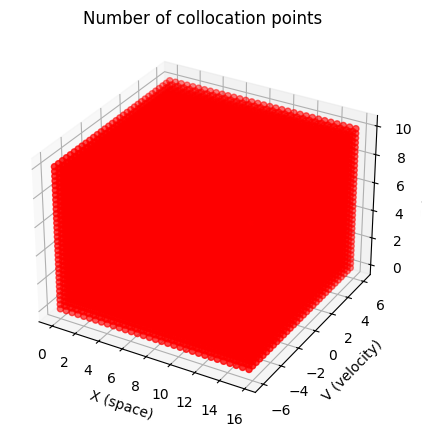

In [41]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train, v_train, t_train, c='r', marker='o')
ax.set_xlabel('X (space)')
ax.set_ylabel('V (velocity)')
ax.set_zlabel('T (time)')
ax.set_title('Number of collocation points')
plt.show()

### 2. Neural network architecture.

In [42]:
class PINN(nn.Module):
  def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS, N_OUTPUT):
    super().__init__()
    activation = nn.Tanh

    layers = [nn.Linear(N_INPUT, N_HIDDEN), activation()] #initialy contains just the 1 layer

    for _ in range(N_LAYERS-1):
      layers.append(nn.Linear(N_HIDDEN, N_HIDDEN)) #adding n-1 layers and n-1 activation functions as well.
      layers.append(activation())

    layers.append(nn.Linear(N_HIDDEN, N_OUTPUT)) #final output layer

    self.net = nn.Sequential(*layers) #unpacking all contents of layers into sequential.

  def forward(self, x, v, t):
    inputs = torch.cat([x, v, t], dim=1)
    outputs = self.net(inputs)

    q = outputs

    return q

### 3. Now defining the losses :
- The P.D.E loss
- The initial condition loss
- The boundary condition loss

In [43]:
def pde_loss(q_pred, E_pred, x_train, v_train, t_train):
  """
  Vlassov : dQ_dt + (V * dQ_dx) - (E * dQ_dv) = 0
  Poisson : dE_dx + integral(Q, dv) - 1 = 0
  IC : Q(x, v, t=0) = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x)) | E(x, v, t=0) = (alpha/k) * torch.cos(k * x)
  BC : Q is period

  Finds physics loss based on the above equation.
  """
  dQ_dt = torch.autograd.grad(q_pred, t_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dx = torch.autograd.grad(q_pred, x_train, torch.ones_like(q_pred), create_graph=True)[0]
  dQ_dv = torch.autograd.grad(q_pred, v_train, torch.ones_like(q_pred), create_graph=True)[0]

  eqn1 = dQ_dt + (v_train * dQ_dx) - (E_pred * dQ_dv) #Vlassov

  return torch.mean(eqn1**2)


def initial_condition_loss(q_pred, x, v, t, alpha = 0.01):
  initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v**2)/2))  * (1 + alpha * torch.sin(k * x))

  return torch.mean((q_pred-initial_condition_Q) ** 2)


def boundary_condition_loss(qlb_pred, qup_pred, t):

  return torch.mean((qup_pred - qlb_pred) ** 2)

In [44]:
def solve_poisson_FFT(q_pred, x, v, t, Nx, Nv, Nt):
  q_copy = q_pred.view(Nx, Nv, Nt).detach() # [Nx, Nv, Nt]
  v_grid = v.view(1, Nv, 1).expand(Nx, Nv, Nt)  # [Nx, Nv, Nt]
  rho = torch.trapz(q_copy, v_grid, dim=1) # [Nx, Nt]

  rhs = 1.0 - rho  #[Nx, Nt]

  rhs_hat = fft(rhs, dim=0)  # shape: [Nx, Nt], basically along the x-axis

  k = fftfreq(Nx,  d=(L / Nx)) * 2 * torch.pi  # shape: [Nx]
  k = k[:, None]  # to broadcast over t
  k[0] = 1e-6

  E_hat = rhs_hat / (1j * k)

  E = ifft(E_hat, dim=0).real

  return E

### 4. Writing the training loop.

In [45]:
model = PINN(3, 80, 5, 1)
optimiser = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 1000

In [46]:
X_train.requires_grad_(True)
v_train.requires_grad_(True)
t_train.requires_grad_(True)
print()

In [47]:
TOTAL_LOSS = []
alpha = 0.01

E, q_pred = None, None

for epoch in range(1, epochs+1):
  model.train()
  optimiser.zero_grad()

  #########################################################################################################################################################
  #Model predictions

  # Initial Condition
  q_pred_init = model(x, v, torch.zeros_like(x)) # q(x, v, 0)
  ic_loss = initial_condition_loss(q_pred_init, x, v, torch.zeros_like(x))

  # Boundary Condition
  q_lb_pred  = model(torch.full_like(t, 0), v, t) # q(0, v, t) - lower bound at x=0
  q_ub_pred = model(torch.full_like(t, L), v, t) # q(16, v, t) - upper bound at x=16
  bcloss1 = boundary_condition_loss(q_lb_pred, q_ub_pred, t)

  q_lb_pred = model(x, torch.full_like(t, -6), t) # q(x, -6, t) - lower bound at v=-6
  q_ub_pred = model(x, torch.full_like(t, 6), t) # q(x, 6, t) - upper bound at v=6
  bcloss2 = boundary_condition_loss(q_lb_pred, q_ub_pred, t)

  bc_loss = bcloss1 + bcloss2

  # Physics Condition
  q_pred = model(X_train, v_train, t_train)

  #########################################################################################################################################################
  # Integration & Fourier transform


  E = solve_poisson_FFT(q_pred, X_train, v, t_train, Nx, Nv, Nt)

  E = E.unsqueeze(1).expand(-1, Nv, -1).reshape(-1, 1)

  #########################################################################################################################################################
  # Physics loss

  physics_loss = pde_loss(q_pred, E, X_train, v_train, t_train)

  # Total loss
  total_loss = physics_loss + 2 * ic_loss + bc_loss
  TOTAL_LOSS.append(total_loss.item())

  total_loss.backward()
  optimiser.step()

  if(epoch%1==0):
    print(f"[{epoch}/{epochs}] Losses - Total:{total_loss.item():.4f}, Physics:{physics_loss.item():.4f}, IC:{ic_loss.item():.4f}, BC:{bc_loss.item():.4f}")

[1/1000] Losses - Total:0.0330, Physics:0.0002, IC:0.0150, BC:0.0028
[2/1000] Losses - Total:0.0420, Physics:0.0002, IC:0.0175, BC:0.0068
[3/1000] Losses - Total:0.0310, Physics:0.0004, IC:0.0135, BC:0.0037
[4/1000] Losses - Total:0.0335, Physics:0.0005, IC:0.0123, BC:0.0084
[5/1000] Losses - Total:0.0331, Physics:0.0004, IC:0.0129, BC:0.0069
[6/1000] Losses - Total:0.0290, Physics:0.0003, IC:0.0129, BC:0.0030
[7/1000] Losses - Total:0.0264, Physics:0.0002, IC:0.0126, BC:0.0010
[8/1000] Losses - Total:0.0275, Physics:0.0002, IC:0.0131, BC:0.0011
[9/1000] Losses - Total:0.0285, Physics:0.0002, IC:0.0134, BC:0.0015
[10/1000] Losses - Total:0.0270, Physics:0.0003, IC:0.0128, BC:0.0012
[11/1000] Losses - Total:0.0249, Physics:0.0003, IC:0.0119, BC:0.0007
[12/1000] Losses - Total:0.0239, Physics:0.0004, IC:0.0111, BC:0.0012
[13/1000] Losses - Total:0.0239, Physics:0.0005, IC:0.0104, BC:0.0026
[14/1000] Losses - Total:0.0237, Physics:0.0006, IC:0.0097, BC:0.0036
[15/1000] Losses - Total:0.02

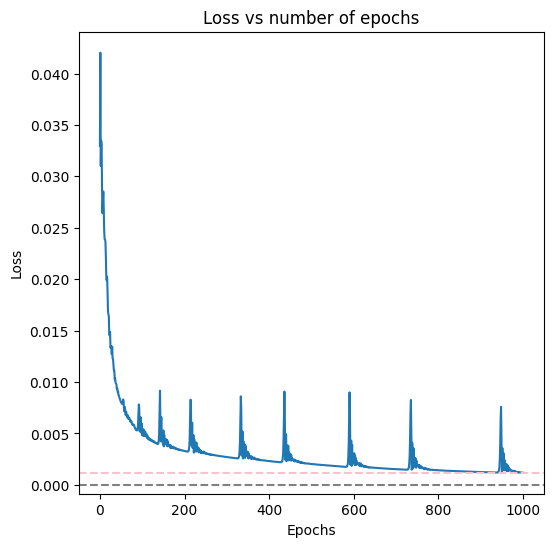

In [48]:
plt.figure(figsize=(6,6))
plt.plot(TOTAL_LOSS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axhline(TOTAL_LOSS[-1], c='pink', linestyle='--')
plt.axhline(0.0, c='gray', linestyle='--')
plt.title('Loss vs number of epochs')
plt.show()

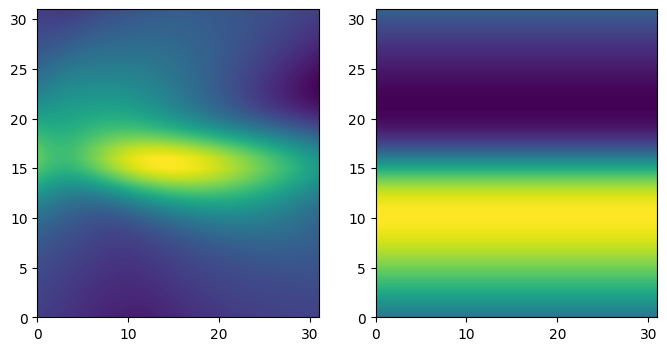

In [49]:
q_last = q_pred.detach().reshape(Nx, Nv, Nt).numpy()
E_last = E.detach().reshape(Nx, Nv, Nt).numpy()

slice_of_time = 0
q_last = q_last[:, :, slice_of_time]
E_last = E_last[:, :, slice_of_time]

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].contourf(q_last, levels = 250)

ax[1].contourf(E_last, levels = 250)

plt.show()

### 5. Testing the neural network.

In [50]:
N_test = 16

In [51]:
X_test = torch.linspace(0, L, N_test).view(-1, 1)
v_test = torch.linspace(-6, 6, N_test).view(-1, 1)
t_test = torch.linspace(0, 10, N_test).view(-1, 1)

V_TEST = v_test
X_TEST = X_test
T_TEST = t_test

X_test, v_test, t_test = torch.meshgrid(X_test.squeeze(), v_test.squeeze(),  t_test.squeeze(), indexing='xy')

X_test = X_test.reshape(-1, 1)
v_test = v_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)


print(f"Shape of X_test : {X_test.shape} and t_test : {t_test.shape} and v_test : {v_test.shape}")

Shape of X_test : torch.Size([4096, 1]) and t_test : torch.Size([4096, 1]) and v_test : torch.Size([4096, 1])


In [52]:
model.eval()
with torch.no_grad():
  q_pred = model(X_test, v_test, t_test)
  E = solve_poisson_FFT(q_pred, X_test, V_TEST, t_test, N_test, N_test, N_test)

In [53]:
q_pred = q_pred.reshape(N_test, N_test, N_test)
X_test = X_test.reshape(N_test, N_test, N_test)
v_test = v_test.reshape(N_test, N_test, N_test)
t_test = t_test.reshape(N_test, N_test, N_test)

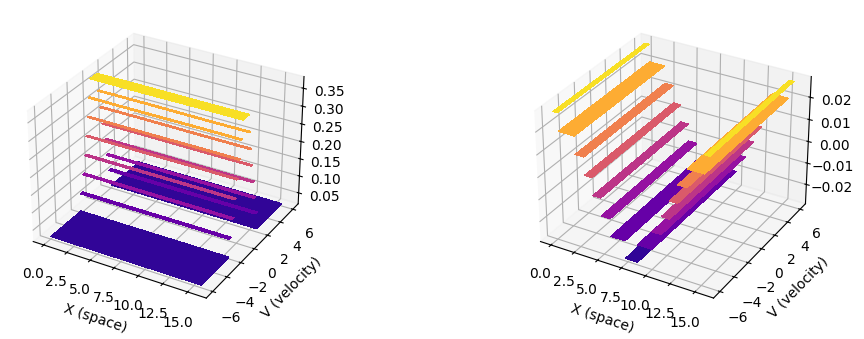

In [54]:
# Initial conditions are defined here just to see what's going on.

alpha = 0.01
initial_condition_Q = (1/((2 * np.pi) ** 0.5)) * (torch.exp(-(v_test**2)/2))  * (1 + alpha * torch.sin(k * X_test))      #No use of v or t here, this is the initial condition.
initial_condition_E = (alpha/k) * torch.cos(k * X_test)


fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_Q[:, :, 0], cmap='plasma')
ax1.set_xlabel('X (space)')
ax1.set_ylabel('V (velocity)')

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.contourf(X_test[:, :, 0], v_test[:, :, 0], initial_condition_E[:, :, 0], cmap='plasma')
ax2.set_xlabel('X (space)')
ax2.set_ylabel('V (velocity)')

plt.show()

In [55]:
q_pred = q_pred.numpy()
X_test = X_test.numpy()
v_test = v_test.numpy()
t_test = t_test.numpy()

In [56]:
print(f"Shape of q_pred, x_test, v_test, t_test is {q_pred.shape}, {X_test.shape}, {v_test.shape} and {t_test.shape}")

Shape of q_pred, x_test, v_test, t_test is (16, 16, 16), (16, 16, 16), (16, 16, 16) and (16, 16, 16)


In [57]:
time_slice = 0

x_slice = X_test[:, :, time_slice]
v_slice = v_test[:, :, time_slice]
q_slice = q_pred[:, :, time_slice]


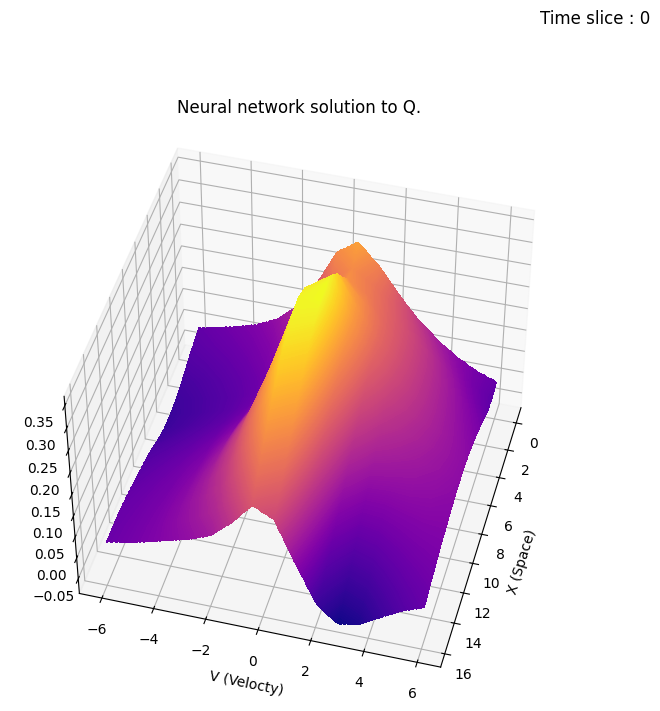

In [58]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.contourf(x_slice, v_slice, q_slice, levels=250, cmap='plasma')
ax1.set_xlabel('X (Space)')
ax1.set_ylabel('V (Velocty)')
ax1.set_title('Neural network solution to Q.')
ax1.view_init(elev=45, azim=15)

plt.suptitle(f"Time slice : {time_slice}")
plt.tight_layout()
plt.show()

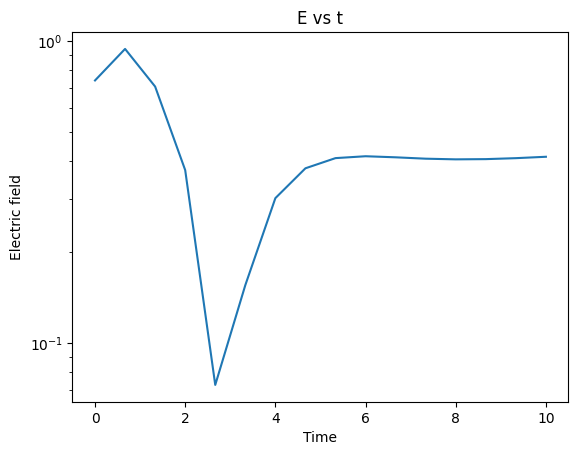

In [59]:
plt.plot(T_TEST, torch.abs(E[N_test//2, :]))
plt.xlabel('Time')
plt.ylabel('Electric field')
plt.yscale('log')
plt.title('E vs t')
plt.show()